In [6]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [129]:
class NHL_Period_Data:
    def __init__(self):
        self.data_x, self.data_y = self.__parseData__()
        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None
        
    def __parseData__(self):
        data = np.genfromtxt("data/periodStats.txt", delimiter=",", dtype=int, skip_header=1)
        return data[...,0:-2],data[...,-1]
    
    def transformData(self, encoder="StandardScaler"):
        cols = list(range(len(self.data_x[0])))
        col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
        col_tr.fit(self.data_x, self.data_y)
        self.data_x = col_tr.transform(self.data_x)
    
    def transformPeriodData(self, encoder="StandardScaler"):
        for data_x, data_y in zip([self.p1_data_x,self.p2_data_x,self.p3_data_x,self.pOT_data_x],
                                  [self.p1_data_y,self.p2_data_y,self.p3_data_y,self.pOT_data_y]):            
            cols = list(range(len(data_x[0])))
            col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
            col_tr.fit(data_x, data_y)
            data_x = col_tr.transform(data_x)
        
    def trainTestSplit(self, split=0.2, period=None):
        if period == 1:
            data_x = self.p1_data_x
            data_y = self.p1_data_y
        elif period == 2:
            data_x = self.p2_data_x
            data_y = self.p2_data_y
        elif period == 3:
            data_x = self.p3_data_x
            data_y = self.p3_data_y
        elif period == 4:
            data_x = self.pOT_data_x
            data_y = self.pOT_data_y
        elif period is None:
            data_x = self.data_x[...,1:]
            data_y = self.data_y
        self.train_x,self.test_x,self.train_y,self.test_y = train_test_split(data_x, data_y, test_size=split)
        
    def selectKBest(self, k=10):
        selector = SelectKBest(k=k).fit(self.train_x, self.train_y)
        self.train_x = selector.transform(self.train_x)
        self.test_x = selector.transform(self.test_x)
        
    def binScores(self):
        if self.train_y is not None:
            self.train_y = np.where(self.train_y > 4, 4, self.train_y)
            self.train_y = np.where(self.train_y < -4, -4, self.train_y)
            self.test_y = np.where(self.test_y > 4, 4, self.test_y)
            self.test_y = np.where(self.test_y < -4, -4, self.test_y)
        else:
            self.data_y = np.where(self.data_y > 4, 4, self.data_y)
            self.data_y = np.where(self.data_y < -4, -4, self.data_y)
    
    def splitByPeriod(self):
        p1x = []
        p2x = []
        p3x = []
        pox = []
        p1y = []
        p2y = []
        p3y = []
        poy = []
        for i,x in enumerate(self.data_x):
            p = x[0]%10
            y = self.data_y[i]
            if p == 1:
                p1x.append(x[1:])
                p1y.append(y)
            elif p == 2:
                p2x.append(x[1:])
                p2y.append(y)
            elif p == 3:
                p3x.append(x[1:])
                p3y.append(y)
            else:
                pox.append(x[1:])
                poy.append(y)
                
        self.p1_data_x = np.array(p1x)
        self.p1_data_y = np.array(p1y)
        self.p2_data_x = np.array(p2x)
        self.p2_data_y = np.array(p2y)
        self.p3_data_x = np.array(p3x)
        self.p3_data_y = np.array(p3y)
        self.pOT_data_x = np.array(pox)
        self.pOT_data_y = np.array(poy)

In [89]:
testD = NHL_Period_Data()
testD.splitByPeriod()
print(testD.p1_data_x[11243])
print(testD.p2_data_x[11243])
print(testD.p3_data_x[11243])
print(len(testD.pOT_data_x))
print(testD.pOT_data_x[3856])

[ 0  9  2  7 11  0  5 14 11  2  1  1  0  2 12  2]
[-2  6  5 10  7  4  7 13 10  3  1  0  0  6 11  3]
[-2  6  0  8  8  3  1  9  7  0  6  0  0  8  9  3]
3857
[0 0 2 0 1 0 0 5 0 2 0 0 0 3 0 2]


In [3]:
data = NHL_Period_Data()
print(data.data_x[0])
data.transformData("MinMaxScaler")
print(data.data_x[0])
data.trainTestSplit()

[ 0  7  6  9  5  4  6 15 11  3  4  2  0  6 10  4]
[0.46666667 0.31818182 0.33333333 0.40909091 0.2173913  0.26666667
 0.35294118 0.48387097 0.34375    0.2        0.21052632 0.08333333
 0.         0.2        0.35714286 0.30769231]


## KNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors':list(range(3,15,2)), 'weights':['uniform','distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size':list(range(10,40)),
          'p':[1,2], 'n_jobs':[-1]}
#knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto', leaf_size=30,
#                           p=2, metric='minkowski', metric_params=None, n_jobs=-1)
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(data.train_x, data.train_y)
pred_vals = model.predict(data.test_x)
print("Predicted values: " + str(pred_vals[0:10]))
print("Actual Values:    " + str(data.test_y[0:10]))
acc = accuracy_score(data.test_y, pred_vals)
print("Validation accuracy: " + str(acc))

/home/brian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Predicted values: [ 0  0  0 -1  1  0 -1 -1  0  0]
Actual Values:    [ 1  0  1  0 -1 -2  1 -1  0 -1]
Validation accuracy: 0.3179036977919659


In [30]:
stand_data = NHL_Period_Data()
stand_data.transformData()
stand_data.trainTestSplit()
#stand_data.selectKBest(15)

In [31]:
#print(model.best_params_)
# {'algorithm': 'auto', 'leaf_size': 20, 'n_jobs': -1, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}

best_knn = KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='auto', leaf_size=8,
                                p=2, n_jobs=-1)
best_knn.fit(stand_data.train_x, stand_data.train_y)
best_pred = best_knn.predict(stand_data.test_x)
b_acc = accuracy_score(stand_data.test_y, best_pred)
print("Acc for leaf_size 8: " + str(b_acc))

Acc for leaf_size 8: 0.33160415003990423


In [33]:
for i in reversed(range(1,17)):
    stand_data.selectKBest(i)
    best_knn.fit(stand_data.train_x, stand_data.train_y)
    best_pred = best_knn.predict(stand_data.test_x)
    b_acc = accuracy_score(stand_data.test_y, best_pred)
    print("Acc for " + str(i) + " features: " + str(b_acc))

Acc for 16 features: 0.33160415003990423
Acc for 15 features: 0.3187017823889332
Acc for 14 features: 0.31670657089651505
Acc for 13 features: 0.3163075285980314
Acc for 12 features: 0.31683958499600956
Acc for 11 features: 0.31683958499600956
Acc for 10 features: 0.3120510774142059
Acc for 9 features: 0.30274009044958766
Acc for 8 features: 0.3026070763500931
Acc for 7 features: 0.3055333865389731
Acc for 6 features: 0.30593242883745675
Acc for 5 features: 0.28757648310720935
Acc for 4 features: 0.29755254056930036
Acc for 3 features: 0.30207501995211494
Acc for 2 features: 0.2870444267092312
Acc for 1 features: 0.30061186485767494


## Random Forest Classifier

In [82]:
stand_data = NHL_Period_Data()
stand_data.transformData("MinMaxScaler")
stand_data.trainTestSplit()
stand_data.binScores()

In [44]:
rf_class = RandomForestClassifier(n_estimators=71,criterion='gini',max_depth=16,min_samples_split=2,
                                 min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                                 max_features='auto',max_leaf_nodes=61,min_impurity_decrease=0.0)

rf_class.fit(stand_data.train_x, stand_data.train_y)
rf_pred = rf_class.predict(stand_data.test_x)
rf_acc = accuracy_score(stand_data.test_y, rf_pred)
print("Acc for random forest: " + str(rf_acc))

Acc for random forest: 0.36179835062516624


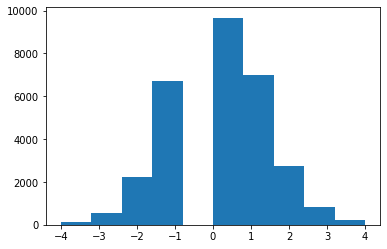

Counter({0: 9670, 1: 7001, -1: 6708, 2: 2753, -2: 2218, 3: 817, -3: 574, 4: 208, -4: 122})


In [70]:
plt.hist(stand_data.train_y)
plt.show()
print(Counter(stand_data.train_y))

In [9]:
rf_grid = RandomForestClassifier()
rf_params = {'n_estimators':[10,35,50,70,90,150],'max_depth':[None,1,3,8,15,25], 
             'min_samples_split':[2,5,10]}
rf_grid_search = GridSearchCV(rf_grid,rf_params)
rf_grid_search.fit(stand_data.train_x, stand_data.train_y)
rf_grid_pred = rf_grid_search.predict(stand_data.test_x)
rf_grid_acc = accuracy_score(stand_data.test_y, rf_grid_pred)
print("Best Fit model acc for grid search: " + str(rf_grid_acc))

/home/brian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Fit model acc for grid search: 0.3627294493216281


In [14]:
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 90}
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}
#Best Fit model acc for grid search: 0.3635275339185954
print("Best Params: " + str(rf_grid_search.best_params_))

Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}


In [83]:
rf_best = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_best.fit(stand_data.train_x, stand_data.train_y)
rf_best_pred = rf_best.predict(stand_data.test_x)
rf_best_acc = accuracy_score(stand_data.test_y, rf_best_pred)
print("Accuracy: " + str(rf_best_acc))

Accuracy: 0.3684490555998936


## Random Forest by Period

In [177]:
periodData = NHL_Period_Data()
periodData.binScores()
periodData.splitByPeriod()
periodData.transformPeriodData("MinMaxScaler")
periodData.trainTestSplit(split=0.2, period=1)

Accuracy: 0.3614939973321476


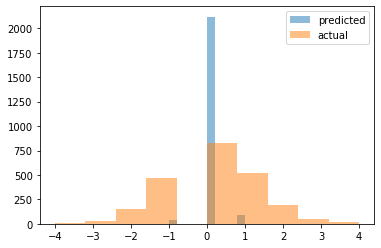

In [178]:
rf_period1 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period1.fit(periodData.train_x, periodData.train_y)
rf_p1_pred = rf_period1.predict(periodData.test_x)
rf_p1_acc = accuracy_score(periodData.test_y, rf_p1_pred)
print("Accuracy: " + str(rf_p1_acc))

plt.hist(rf_p1_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.3072476656291685


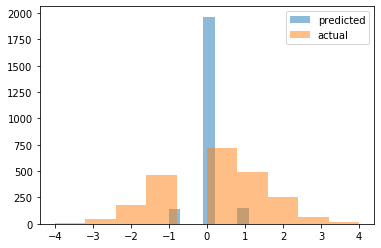

In [172]:
periodData.trainTestSplit(split=0.2, period=2)
rf_period2 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period2.fit(periodData.train_x, periodData.train_y)
rf_p2_pred = rf_period2.predict(periodData.test_x)
rf_p2_acc = accuracy_score(periodData.test_y, rf_p2_pred)

print("Accuracy: " + str(rf_p2_acc))
plt.hist(rf_p2_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.341929746554024


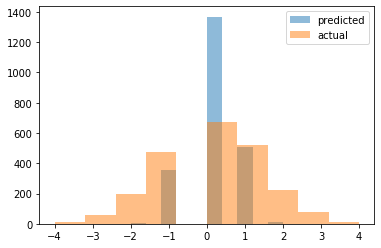

In [173]:
periodData.trainTestSplit(split=0.2, period=3)
rf_period3 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period3.fit(periodData.train_x, periodData.train_y)
rf_p3_pred = rf_period3.predict(periodData.test_x)
rf_p3_acc = accuracy_score(periodData.test_y, rf_p3_pred)

print("Accuracy: " + str(rf_p3_acc))
plt.hist(rf_p3_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

OT samples: 3085
Accuracy: 0.7124352331606217


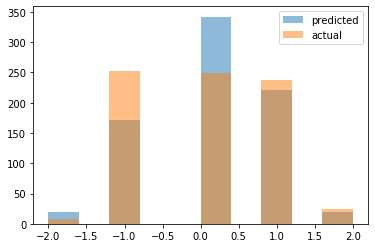

In [174]:
periodData.trainTestSplit(split=0.2, period=4)
print("OT samples: " + str(len(periodData.train_x)))
rf_periodOT = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_periodOT.fit(periodData.train_x, periodData.train_y)
rf_pOT_pred = rf_periodOT.predict(periodData.test_x)
rf_pOT_acc = accuracy_score(periodData.test_y, rf_pOT_pred)

print("Accuracy: " + str(rf_pOT_acc))
plt.hist(rf_pOT_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()